# Auswertung Automatisierungstechnik Bonuspraktikum 1

In [194]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import pandas as pd
import numpy as np
import os
from glob import glob

from scipy.interpolate import interp1d

DATA_PATH = os.path.join(os.getcwd(), 'data')
PLOT_PATH = os.path.join(os.getcwd(), 'plots')

def read_data(txt_path:str, start:float=0, end:float=np.inf) -> pd.DataFrame:
    columns=["time", "V_Motor", "Pendelauslenkung in °", "Abstand vom Start in m"]
    df = pd.read_csv(txt_path,sep='\t', names = columns, header=None)
    
    df['time'] = pd.to_timedelta(df['time'], unit='s')
    df['time'] = df['time'].apply(lambda x: x.total_seconds())    
    df.index = df['time']
    df['Abstand vom Start in m'] = df['Abstand vom Start in m'] / 100000
    return df[["V_Motor", "Pendelauslenkung in °", "Abstand vom Start in m"]]

def interpolate_df(df):
    df_interpol = pd.DataFrame()
    f = [interp1d(df.index, df[x]) for x in df.columns]

    start, end = min(df.index.to_list()), max(df.index.to_list())
    new_index = np.arange(start, end, step=0.003)

    for i, col in enumerate(df.columns):
        df_interpol[col] = f[i](new_index)
    df_interpol.index = new_index
    return df_interpol

def create_plot(df):
    fig, ax = plt.subplots(figsize=(16, 4), layout='constrained')

    ax3 = ax.twinx()
    rspine = ax3.spines['right']
    rspine.set_position(('axes', 1.05))
    ax3.set_frame_on(True)
    ax3.patch.set_visible(False)

    df['V_Motor'].plot(ax=ax, style='b-')
    df['Pendelauslenkung in °'].plot(ax=ax, style='r-', secondary_y=True)
    df['Abstand vom Start in m'].plot(ax=ax3, style='g-')

    ax.set_xlabel(r'$t\ [s]$')    
    ax.set_ylabel(r'$V_{Motor}\ [V]$')
    ax.yaxis.label.set_color('blue')
    ax.tick_params(axis='y', colors='blue')

    ax2 = ax.right_ax
    ax2.set_ylabel(r'$\alpha_{Pendel}\ [°]$')
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')

    ax3.set_ylabel(r'$d_{Start}\ [m]$')
    ax3.yaxis.label.set_color('green')
    ax3.tick_params(axis='y', colors='green')
    
    return fig, ax, ax2, ax3

def annot_max(df, ax=None):
    max_value = df.loc[df['Pendelauslenkung in °'].idxmax()]
    xmax = max_value.name
    ymax = max_value['Pendelauslenkung in °']
    
    text= r"t={:.3f}s, ".format(xmax) + r'$\alpha_{Pendel}=$' + r'{:.2f}°'.format(ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
            arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    xpos = 0.2 + xmax/max(df.index)
    ax.annotate(text, xy=(xmax, ymax), xytext=(xpos,1.1), **kw)

## Default-Regler

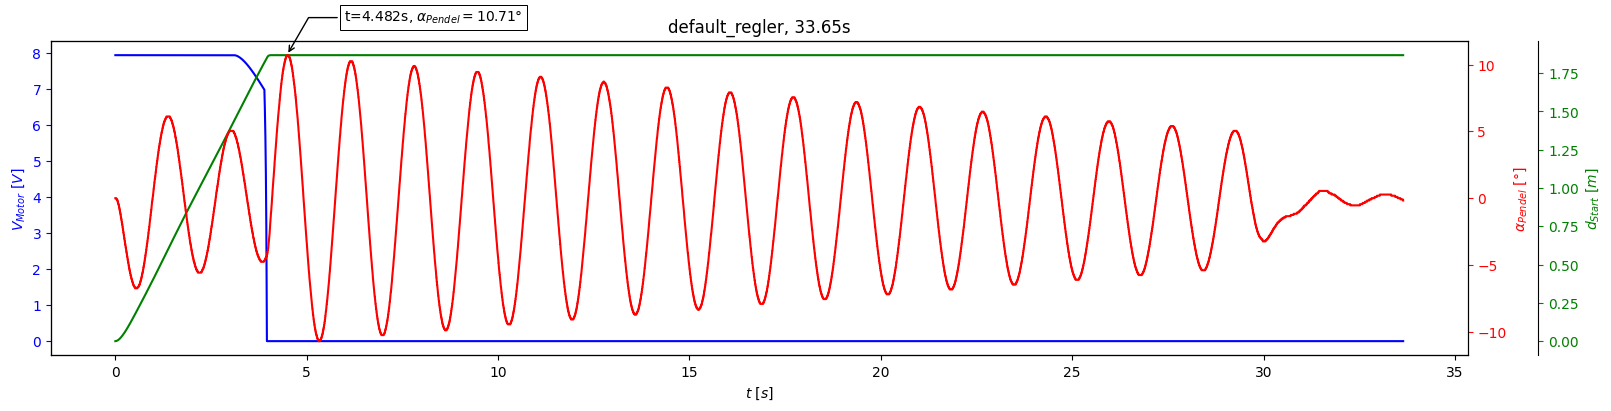

FileNotFoundError: [Errno 2] No such file or directory: 'g:\\Dokumente\\FH Dortmund\\Module\\SoSe23\\Automatisierungstechnik\\Bonuspraktikum_02\\plots\\default_regler, 33.65s\\.png.png'

<Figure size 640x480 with 0 Axes>

In [195]:
# get csv data
results = glob(os.path.join(os.path.join(DATA_PATH, "*.txt")))

for r in results:
    file_name = ' '.join(os.path.basename(r).split(' ')[0:-1])
    df = read_data(r)

    # interpolate
    df_interpol = interpolate_df(df)

    # create plot
    _, ax1, ax2, ax3 = create_plot(df_interpol)

    annot_max(df, ax=ax2)
    
    title = file_name + f", {round(max(df.index), 2)}s"

    plt.title(title)
    plt.show()
    plt.savefig(os.path.join(PLOT_PATH, title))
